In [1]:
### Importations de base
import numpy as np
import pandas as pd
import os
import gc
import time
from contextlib import contextmanager
import warnings

### Importations pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import missingno as msno

### Importations pour la manipulation des données
import re
from scipy import stats

### Importations pour le Machine Learning
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Paramètres pandas
pd.set_option('mode.chained_assignment', None)  # Pour éviter la survenue de messages d'erreur lors de la création d'un nouveau dataframe à partir d'un existant
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Optionnel : Filtrer les avertissements
from warnings import filterwarnings
filterwarnings('ignore')

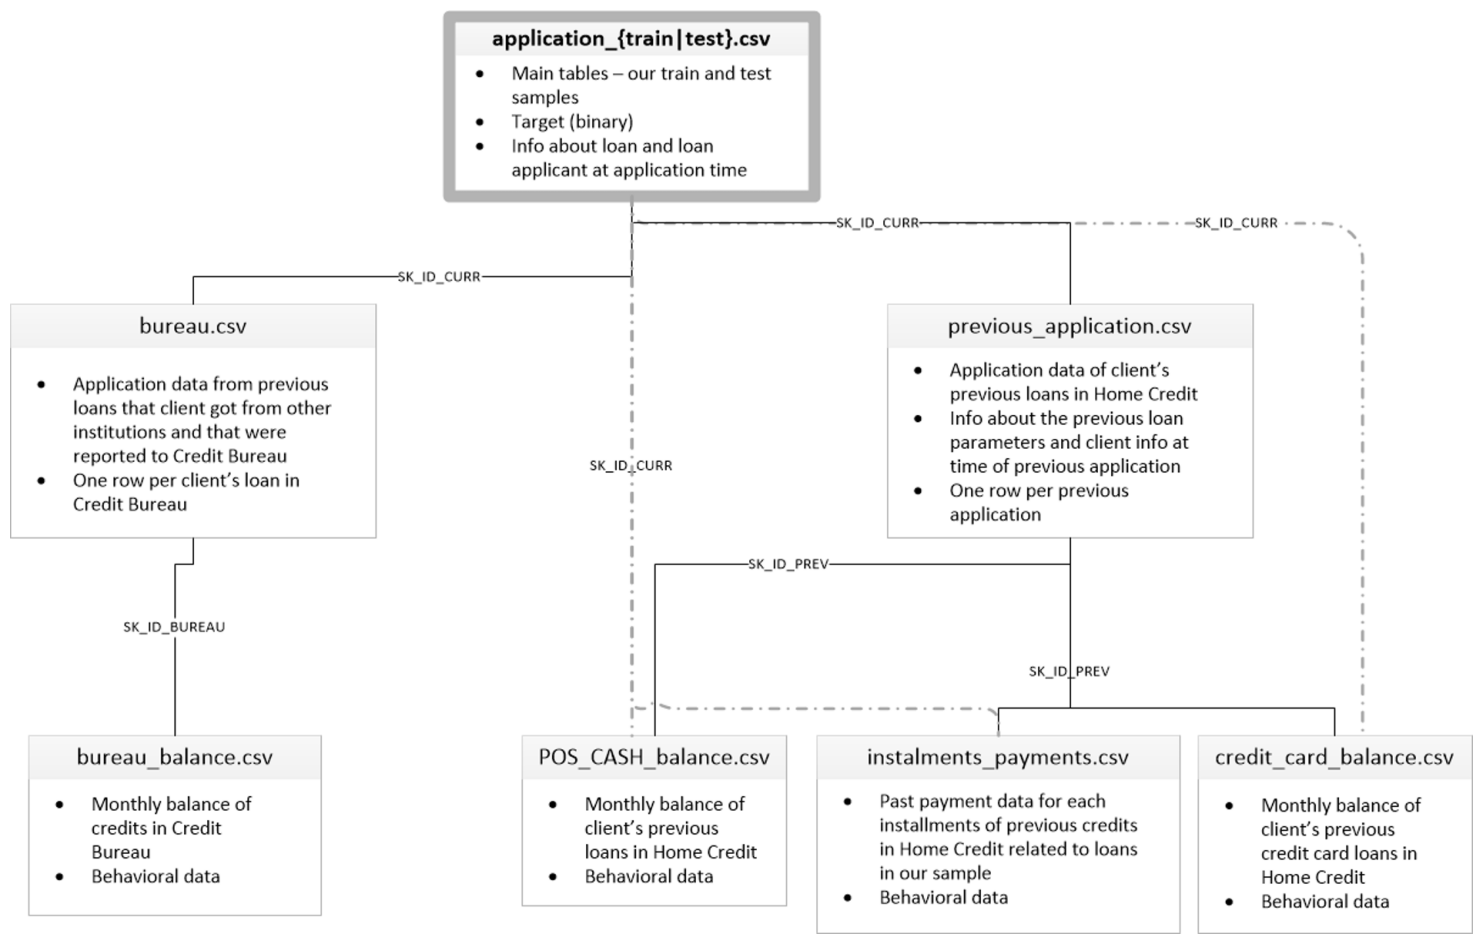

In [2]:
# Chemin vers l'image
image_path = 'home_credit.png'

# Ouvrir l'image
image = Image.open(image_path)
image = image.convert('RGB')
# Redimensionner l'image (ajuster les dimensions selon vos besoins)
image_resized = image.resize((1900, 1200))

# Ajuster la taille de la figure
plt.figure(figsize=(20, 12))

# Afficher l'image
plt.imshow(image_resized)
plt.axis('off')  # Pour cacher les axes
plt.show()

## Fichier description colonnes 'Home Credit_colums_description'

In [3]:
# Chemin vers le répertoire des données
path_dir = r"C:/Users/Bruno/Desktop/OCR/Projet/P7 - Implémentez un modèle de scoring/Data"
# Nom du fichier de description des colonnes
file_name = 'HomeCredit_columns_description.csv'

# Construction du chemin complet vers le fichier
path = os.path.join(path_dir, file_name)

description = pd.read_csv(path, encoding='latin1', index_col=[0])

description.head()


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [4]:
description.shape

(219, 4)

In [5]:
description.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 1 to 221
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Table        219 non-null    object
 1   Row          219 non-null    object
 2   Description  219 non-null    object
 3   Special      86 non-null     object
dtypes: object(4)
memory usage: 8.6+ KB


In [6]:
def transform_categorical_features(df):
    """
    Transforme les variables catégoriques en variables numériques.
    
    - Les variables catégoriques binaires sont factorisées.
    - Les variables catégoriques non binaires sont converties en variables dummy (one-hot encoding).
    
    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les variables à transformer.
    
    Returns:
    pd.DataFrame: Le DataFrame avec les variables transformées.
    """
    # Identification des variables catégoriques binaires
    binary_categorical_columns = df.select_dtypes(include='object').nunique().to_frame()
    binary_categorical_columns = list(binary_categorical_columns[binary_categorical_columns[0] == 2].index)
    
    # Factorisation des variables catégoriques binaires
    for column in binary_categorical_columns:
        df[column] = df[column].factorize()[0]
    
    # Identification des variables catégoriques non binaires
    non_binary_categorical_columns = df.select_dtypes(include='object').columns
    
    # Conversion des variables catégoriques non binaires en variables dummy
    for column in non_binary_categorical_columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop(columns=[column], inplace=True)
    
    return df

## Fichier principaux 'Application_train & test'
### Fichier Train

In [7]:
# Nom du fichier 
file_name = 'application_train.csv'
path = os.path.join(path_dir, file_name)

anciens_clients = pd.read_csv(path, encoding='latin1')
anciens_clients.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
anciens_clients.shape

(307511, 122)

### Fichier Test

In [9]:
# Nom du fichier
file_name = 'application_test.csv'
path = os.path.join(path_dir, file_name)

nouveaux_clients = pd.read_csv(path, encoding='latin1')
nouveaux_clients.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [10]:
nouveaux_clients.shape

(48744, 121)

### Fusion des fichiers principaux

In [11]:
# Encodage one-hot pour les colonnes catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    """
    Transforme les variables catégorielles en variables numériques.
    
    - Les variables catégorielles sont transformées en variables dummy (one-hot encoding).
    - Les valeurs NaN peuvent être considérées comme une catégorie à part.
    
    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les variables à transformer.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame, list: Le DataFrame avec les variables transformées et la liste des nouvelles colonnes.
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


### Prétraitement

In [12]:
# Prétraitement des fichiers application_train.csv et application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    """
    Charge et prétraite les fichiers application_train.csv et application_test.csv.
    
    - Fusionne les ensembles de données d'entraînement et de test.
    - Effectue l'encodage des variables catégorielles.
    - Crée de nouvelles caractéristiques basées sur les données existantes.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité.
    """
    # Chemins absolus vers les fichiers CSV
    train_path = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data\application_train.csv"
    test_path = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data\application_test.csv"
    
    # Lire les données d'entraînement et de test
    df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons d'entraînement et de test
    print("Nombre d'échantillons d'entraînement : {}, Nombre d'échantillons de test : {}".format(len(df), len(test_df)))
    
    # Fusionner les ensembles de données d'entraînement et de test
    df = df.append(test_df).reset_index()
    
    # Optionnel : Supprimer les applications avec CODE_GENDER égal à XNA (dans l'ensemble d'entraînement)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encodage binaire pour les caractéristiques catégorielles
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Encodage one-hot pour les autres caractéristiques catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Remplacer les valeurs spécifiques par NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Créer de nouvelles caractéristiques (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Libérer la mémoire
    del test_df
    gc.collect()
    
    return df

In [13]:
# Charger et prétraiter les données des clients
Clients = application_train_test(num_rows=None, nan_as_category=False)

# Afficher les cinq premières lignes du DataFrame résultant
Clients.head()

Nombre d'échantillons d'entraînement : 307511, Nombre d'échantillons de test : 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,...,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION

## Fichier bureaux

**Bureau :** Contient des informations sur les crédits antérieurs des clients auprès d'autres institutions financières.

In [14]:
# Nom du fichier 
file_name = 'bureau.csv'
path = os.path.join(path_dir, file_name)

bureau = pd.read_csv(path, encoding='latin1')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
bureau.shape

(1716428, 17)

In [16]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


---
**Bureau_balance :** Donées mensuelles qui fournissents des informations sur les crédits antérieurs présents dans 'bureau.csv'. Chaques lignes correspondent à un mois de crédit, et un crédit unique peut avoir plusieurs lignes, une pour chaque mois de sa durée.

In [17]:
# Nom du fichier 
file_name = 'bureau_balance.csv'
path = os.path.join(path_dir, file_name)

bureau_balance = pd.read_csv(path, encoding='latin1')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [18]:
bureau_balance.shape

(27299925, 3)

In [19]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [20]:
import gc ## gestion de la mémoire 

# Prétraitement des fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Charge et prétraite les fichiers bureau.csv et bureau_balance.csv.
    
    - Effectue l'encodage des variables catégorielles.
    - Effectue des agrégations sur les données et fusionne les jeux de données.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité avec les données fusionnées et agrégées.
    """
    # Chemins absolus vers les fichiers CSV
    bureau_path = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data\bureau.csv"
    bureau_balance_path = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data\bureau_balance.csv"
    
    # Lire les données bureau et bureau_balance
    bureau = pd.read_csv(bureau_path, nrows=num_rows)
    bureau_balance = pd.read_csv(bureau_balance_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons dans bureau et bureau_balance
    print("Nombre d'échantillons dans bureau : {}, Nombre d'échantillons dans bureau_balance : {}".format(len(bureau), len(bureau_balance)))
    
    # Encodage one-hot pour les colonnes catégorielles
    bureau_balance, bb_cat = one_hot_encoder(bureau_balance, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégations sur bureau_balance et fusion avec bureau
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    
    # Libérer la mémoire
    del bureau_balance, bb_agg
    gc.collect()
    
    # Agrégations des caractéristiques numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Agrégations des caractéristiques catégorielles
    cat_aggregations = {cat: ['mean'] for cat in bureau_cat}
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Agrégations pour les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    # Libérer la mémoire
    del active, active_agg
    gc.collect()
    
    # Agrégations pour les crédits clôturés
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    # Libérer la mémoire
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [21]:
bureau_data = bureau_and_balance(num_rows=None, nan_as_category=True)

bureau_data.head()

Nombre d'échantillons dans bureau : 1716428, Nombre d'échantillons dans bureau_balance : 27299925


,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.00000,0.000,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Fichier previous_application

**Previous_application :** Recense les demandes de prêts précédentes des clients auprès de Prêt à dépenser. Chaque ligne correspond à une demande antérieure de prêt

In [22]:
# Nom du fichier 
file_name = 'previous_application.csv'
path = os.path.join(path_dir, file_name)

previous_application = pd.read_csv(path, encoding='latin1')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
previous_application.shape

(1670214, 37)

In [24]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [25]:
# Affichage du nombre d'ID clients uniques (SK_ID_CURR)
print(f"Nombre d'ID clients uniques dans previous_application : {len(previous_application['SK_ID_CURR'].unique())}")

Nombre d'ID clients uniques dans previous_application : 338857


In [26]:
# Prétraitement du fichier previous_application.csv
def previous_applications(num_rows=None, nan_as_category=True):
    """
    Charge et prétraite le fichier previous_application.csv.
    
    - Effectue l'encodage des variables catégorielles.
    - Remplace les valeurs spéciales par NaN.
    - Ajoute de nouvelles caractéristiques basées sur les données existantes.
    - Effectue des agrégations sur les données et fusionne les jeux de données approuvés et refusés.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité avec les données fusionnées et agrégées.
    """
    # Chemin absolu vers le fichier CSV
    prev_path = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data\previous_application.csv"
    
    # Lire les données previous_application
    prev = pd.read_csv(prev_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons dans previous_application
    print(f"Nombre d'échantillons dans previous_application : {len(prev)}")
    
    # Encodage one-hot pour les colonnes catégorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=nan_as_category)
    
    # Remplacer les valeurs spéciales par NaN
    days_cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in days_cols:
        prev[col].replace(365243, np.nan, inplace=True)
    
    # Ajouter une nouvelle caractéristique : pourcentage de la valeur demandée par rapport à la valeur reçue
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Agrégations des caractéristiques numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Agrégations des caractéristiques catégorielles
    cat_aggregations = {cat: ['mean'] for cat in cat_cols}
    
    # Agrégation par SK_ID_CURR
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Agrégations pour les demandes approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Agrégations pour les demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Libérer la mémoire
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

In [27]:
# Charger et prétraiter les données previous_application
previous_app_data = previous_applications(num_rows=None, nan_as_category=True)

# Afficher les cinq premières lignes du DataFrame résultant
previous_app_data.head()

Nombre d'échantillons dans previous_application : 1670214


,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_CONTRACT_STATUS_nan_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,...,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional / Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_CHANNEL_TYPE_nan_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_

### Fichier POS_CASH_BALANCE (soldes)

**POS_CASH_BALANCE :** Ces données mensuelles concernent les prêts au point de vente ou les prêts en espèces contractés par les clients auprès de Prêt à dépenser. Chaque ligne représente un mois de prêt au point de vente ou de prêt en espèces, avec plusieurs lignes possibles pour un même prêt.

In [28]:
# Nom du fichier 
file_name = 'POS_CASH_BALANCE.csv'
path = os.path.join(path_dir, file_name)

pos_cash_balance = pd.read_csv(path, encoding='latin1')
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [29]:
pos_cash_balance.shape

(10001358, 8)

In [30]:
pos_cash_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [31]:
# Prétraitement du fichier POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    """
    Charge et prétraite le fichier POS_CASH_balance.csv.
    
    - Effectue l'encodage des variables catégorielles.
    - Calcule des agrégations sur les données.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité avec les données agrégées.
    """
    
    # Chemin vers le répertoire des données
    path_dir = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data"

    # Chemin absolu vers le fichier CSV
    pos_cash_path = os.path.join(path_dir, 'POS_CASH_BALANCE.csv')
    
    # Lire les données POS_CASH_BALANCE
    pos = pd.read_csv(pos_cash_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons dans POS_CASH_BALANCE
    print(f"Nombre d'échantillons dans POS_CASH_BALANCE : {len(pos)}")
    
    # Encodage one-hot pour les colonnes catégorielles
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=nan_as_category)
    
    # Définir les agrégations pour les colonnes numériques et catégorielles
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],  # Agrégations pour la colonne MONTHS_BALANCE
        'SK_DPD': ['max', 'mean'],                  # Agrégations pour la colonne SK_DPD
        'SK_DPD_DEF': ['max', 'mean']               # Agrégations pour la colonne SK_DPD_DEF
    }
    # Ajouter les agrégations pour les colonnes catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Effectuer les agrégations par SK_ID_CURR
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Compter le nombre de comptes POS cash pour chaque client
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Libérer la mémoire en supprimant le DataFrame intermédiaire et en appelant le garbage collector
    del pos
    gc.collect()
    
    return pos_agg

In [32]:
# Charger et prétraiter les données POS_CASH_BALANCE
solde_agg = pos_cash(num_rows=None, nan_as_category=True)
solde_agg.head()

Nombre d'échantillons dans POS_CASH_BALANCE : 10001358


,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


### Fichier credit_card_balance

**Credit_card_balance :** Ce fichier contient des données mensuelles sur les cartes de crédit des clients. Chaque ligne correspond à un mois de solde de carte de crédit, avec plusieurs lignes possibles pour une même carte de crédit.

In [33]:
# Nom du fichier 
file_name = 'credit_card_balance.csv'
path = os.path.join(path_dir, file_name)

credit_card_balance = pd.read_csv(path, encoding='latin1')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [34]:
# Affichage du nombre d'ID clients uniques (SK_ID_CURR)
print(f"Nombre d'ID clients uniques dans credit_card_balance : {len(credit_card_balance['SK_ID_CURR'].unique())}")

Nombre d'ID clients uniques dans credit_card_balance : 103558


In [36]:
credit_card_balance.shape

(3840312, 23)

In [37]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [38]:
# Prétraitement du fichier credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Charge et prétraite le fichier credit_card_balance.csv.
    
    - Effectue l'encodage des variables catégorielles.
    - Calcule des agrégations générales sur les données.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité avec les données agrégées.
    """
    
    # Chemin vers le répertoire des données
    path_dir = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data"

    # Chemin absolu vers le fichier CSV
    cc_path = os.path.join(path_dir, 'credit_card_balance.csv')
    
    # Lire les données credit_card_balance
    cc = pd.read_csv(cc_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons dans credit_card_balance
    print(f"Nombre d'échantillons dans credit_card_balance : {len(cc)}")
    
    # Encodage one-hot pour les colonnes catégorielles
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=nan_as_category)
    
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Compter le nombre de lignes de cartes de crédit pour chaque client
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Libérer la mémoire en supprimant le DataFrame intermédiaire et en appelant le garbage collector
    del cc
    gc.collect()
    
    return cc_agg

In [39]:
# Charger et prétraiter les données credit_card_balance
cc_balance_agg = credit_card_balance(num_rows=None, nan_as_category=True)
cc_balance_agg.head()

Nombre d'échantillons dans credit_card_balance : 3840312


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_S

### Fichiers installments_payment

**Installments_payment :** Ce fichier documente l'historique des paiements pour les prêts antérieurs. Chaque ligne représente un paiement effectué ou manqué.


In [40]:
# Nom du fichier 
file_name = 'installments_payments.csv'
path = os.path.join(path_dir, file_name)

installments_payments = pd.read_csv(path, encoding='latin1')
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [41]:
# Affichage du nombre d'ID clients uniques (SK_ID_CURR)
print(f"Nombre d'ID clients uniques dans credit_card_balance : {len(installments_payments['SK_ID_CURR'].unique())}")

Nombre d'ID clients uniques dans credit_card_balance : 339587


In [43]:
installments_payments.shape

(13605401, 8)

In [44]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [45]:
# Prétraitement du fichier installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Charge et prétraite le fichier installments_payments.csv.
    
    - Effectue l'encodage des variables catégorielles.
    - Calcule des pourcentages et des différences de paiement pour chaque versement.
    - Calcule les jours de retard et les jours avant échéance.
    - Calcule des agrégations sur les données.
    
    Parameters:
    num_rows (int): Nombre de lignes à lire (pour un échantillonnage). None pour lire toutes les lignes.
    nan_as_category (bool): Indique si les valeurs NaN doivent être considérées comme une catégorie.
    
    Returns:
    pd.DataFrame: Le DataFrame prétraité avec les données agrégées.
    """
    
    # Chemin vers le répertoire des données
    path_dir = r"C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data"
    # Chemin absolu vers le fichier CSV
    ins_path = os.path.join(path_dir, 'installments_payments.csv')
    
    # Lire les données installments_payments
    ins = pd.read_csv(ins_path, nrows=num_rows)
    
    # Afficher le nombre d'échantillons dans installments_payments
    print(f"Nombre d'échantillons dans installments_payments : {len(ins)}")
    
    # Encodage one-hot pour les colonnes catégorielles
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=nan_as_category)
    
    # Calcul du pourcentage et de la différence payée à chaque versement
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Calcul des jours de retard et des jours avant échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Définir les agrégations pour les colonnes numériques et catégorielles
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],  # Nombre unique de versions de versement
        'DPD': ['max', 'mean', 'sum'],          # Jours de retard (max, mean, sum)
        'DBD': ['max', 'mean', 'sum'],          # Jours avant échéance (max, mean, sum)
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],  # Pourcentage de paiement (max, mean, sum, var)
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],  # Différence de paiement (max, mean, sum, var)
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],       # Montant du versement (max, mean, sum)
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],   # Montant payé (min, max, mean, sum)
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']    # Jours d'entrée de paiement (max, mean, sum)
    }
    # Ajouter les agrégations pour les colonnes catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Effectuer les agrégations par SK_ID_CURR
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Compter le nombre de comptes d'installments pour chaque client
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Libérer la mémoire en supprimant le DataFrame intermédiaire et en appelant le garbage collector
    del ins
    gc.collect()
    
    return ins_agg

In [46]:
# Charger et prétraiter les données installments_payments
installments_agg = installments_payments(num_rows=None, nan_as_category=True)
installments_agg.head()

Nombre d'échantillons dans installments_payments : 13605401


,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,17397.900,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,560835.360,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,10573.965,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,17656.245,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


# Jointure de tous les fichiers prétraités


In [47]:
# Liste des DataFrames avec leurs noms
dataframes = {
    'Clients': Clients,
    'bureau_data': bureau_data,
    'previous_app_data': previous_app_data,
    'solde_agg': solde_agg,
    'cc_balance_agg': cc_balance_agg,
    'installments_agg': installments_agg
}

# Afficher la longueur de chaque DataFrame avec son nom
[print(f"Nombre de lignes dans le DataFrame {name} : {len(df)}") for name, df in dataframes.items()]

Nombre de lignes dans le DataFrame Clients : 356251
Nombre de lignes dans le DataFrame bureau_data : 305811
Nombre de lignes dans le DataFrame previous_app_data : 338857
Nombre de lignes dans le DataFrame solde_agg : 337252
Nombre de lignes dans le DataFrame cc_balance_agg : 103558
Nombre de lignes dans le DataFrame installments_agg : 339587


[None, None, None, None, None, None]

In [48]:

# Jointure des données clients et des données de bureau
DataFinal = pd.merge(Clients, bureau_data.reset_index(), how='outer')
# Jointure des données précédentes avec les données de demandes de prêts précédentes
DataFinal = pd.merge(DataFinal, previous_app_data.reset_index(), how='outer')
# Jointure des données précédentes avec les données de solde agrégé
DataFinal = pd.merge(DataFinal, solde_agg.reset_index(), how='outer')
# Jointure des données précédentes avec les données agrégées de cartes de crédit
DataFinal = pd.merge(DataFinal, cc_balance_agg.reset_index(), how='outer')
# Jointure des données précédentes avec les données de paiements d'installments
DataFinal = pd.merge(DataFinal, installments_agg.reset_index(), how='outer')


DataFinal.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX

In [49]:
# Suppression des lignes sans genre
DataFinal = DataFinal[DataFinal['CODE_GENDER'].notna()]

# Suppression colonnes inutiles :
del DataFinal['index']

# Afficher le DataFrame final après nettoyage
DataFinal

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STA

In [50]:
# Recherche des valeurs infinies dans le DataFrame final

# Vérification des valeurs infinies positives
infinite_positives = DataFinal.isin([np.inf])
num_infinite_positives = infinite_positives.sum().sum()
print(f"Nombre de valeurs infinies positives : {num_infinite_positives}")

# Vérification des valeurs infinies négatives
infinite_negatives = DataFinal.isin([-np.inf])# Identification des colonnes contenant des valeurs infinies dans le DataFrame final

# Trouver les noms des colonnes contenant des valeurs infinies
columns_with_infinity = list(DataFinal.columns.to_series()[np.isinf(DataFinal).any()])
print(f"Colonnes contenant des valeurs infinies : {columns_with_infinity}")

# Ajouter la colonne 'TARGET' pour l'affichage
columns_with_infinity.append('TARGET')

# Afficher les lignes et colonnes spécifiques contenant des valeurs infinies
rows_with_infinity = DataFinal[np.isinf(DataFinal).any(1)]
rows_with_infinity[columns_with_infinity]
num_infinite_negatives = infinite_negatives.sum().sum()
print(f"Nombre de valeurs infinies négatives : {num_infinite_negatives}")

Nombre de valeurs infinies positives : 21
Colonnes contenant des valeurs infinies : ['PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
Nombre de valeurs infinies négatives : 0


In [51]:
# Identification des colonnes contenant des valeurs infinies dans le DataFrame final

# Trouver les noms des colonnes contenant des valeurs infinies
columns_with_infinity = list(DataFinal.columns.to_series()[np.isinf(DataFinal).any()])
print(f"Colonnes contenant des valeurs infinies : {columns_with_infinity}")

# Ajouter la colonne 'TARGET' pour l'affichage
columns_with_infinity.append('TARGET')

# Afficher les lignes et colonnes spécifiques contenant des valeurs infinies
rows_with_infinity = DataFinal[np.isinf(DataFinal).any(1)]
rows_with_infinity[columns_with_infinity]

Colonnes contenant des valeurs infinies : ['PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']


,PREV_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MAX,INSTAL_PAYMENT_PERC_MAX,TARGET
5687,1.000000,1.00000,inf,0.0
60475,1.276243,NaN,inf,0.0
79075,1.111111,1.00000,inf,0.0
89015,1.567712,NaN,inf,0.0
98506,1.118620,1.11862,inf,1.0
126765,1.111111,NaN,inf,0.0
128788,NaN,NaN,inf,0.0
140423,1.111111,NaN,inf,0.0
152084,1.011024,NaN,inf,0.0
167133,1.250038,NaN,inf,0.0


- La majorité des valeurs infinies sont présentes dans la colonne **INSTAL_PAYMENT_PERC_MAX**. Il y a deux lignes où la colonne **TARGET** est égale à **1** et une ligne où TARGET est **non définie**.

- Suppression de la **ligne 201082** car elle a un TARGET de 0, et remplacement des autres valeurs infinies par le maximum de la colonne multiplié par 10 pour éviter de supprimer deux lignes avec TARGET égal à 1.



In [52]:
# Identifier les lignes contenant des valeurs infinies
rows_with_infinity = DataFinal.index[np.isinf(DataFinal).any(1)].tolist()

# Créer un DataFrame sans les lignes contenant des valeurs infinies
DataFinal_no_inf = DataFinal.drop(index=rows_with_infinity)

# Trouver le maximum de la colonne 'INSTAL_PAYMENT_PERC_MAX' dans le DataFrame sans valeurs infinies
max_instal_payment_perc = DataFinal_no_inf['INSTAL_PAYMENT_PERC_MAX'].max()

# Afficher le maximum trouvé
print(f"Le maximum de la colonne 'INSTAL_PAYMENT_PERC_MAX' est : {max_instal_payment_perc}")

Le maximum de la colonne 'INSTAL_PAYMENT_PERC_MAX' est : 194250.0


In [53]:
# Remplacer les valeurs infinies dans la colonne 'INSTAL_PAYMENT_PERC_MAX' par le maximum multiplié par 10
DataFinal['INSTAL_PAYMENT_PERC_MAX'] = DataFinal['INSTAL_PAYMENT_PERC_MAX'].replace(np.inf, max_instal_payment_perc * 10)

# Supprimer la ligne avec l'index 201082 
DataFinal = DataFinal.drop(index=201082)

La méthode de remplacement des valeurs infinies par le maximum multiplié par 10 :
### Avantages :

1. **Simplicité :** Le remplacement des valeurs infinies par un grand nombre (max * 10) est simple à implémenter.

2. **Préservation des données :** Cette méthode permet de conserver les lignes contenant des valeurs infinies au lieu de les supprimer, ce qui peut être important si ces lignes contiennent d'autres informations précieuses.

3. **Consistance :** Utiliser une valeur basée sur les données existantes (max * 10) peut maintenir la consistance des valeurs dans la colonne.

### Inconvénients :

1. **Biais potentiel :** Remplacer les valeurs infinies par un nombre très élevé peut introduire un biais dans les analyses ou modèles qui suivent, car ce grand nombre peut influencer les résultats de manière disproportionnée.
   
2. **Choix arbitraire :** Le facteur 10 est arbitraire et peut ne pas être approprié dans tous les contextes. Par exemple, il pourrait être trop grand ou trop petit en fonction de la distribution des données.

La méthode de remplacement des valeurs infinies par le maximum multiplié par 10 est simple et peut être efficace, mais elle n'est pas sans risques. Elle peut introduire un biais si le facteur multiplicatif n'est pas bien choisi. Selon le contexte et la distribution des données, il pourrait être préférable d'utiliser une méthode d'imputation plus robuste, comme la médiane, la moyenne, ou des techniques d'imputation avancées.


In [54]:
# Calculer le nombre total de valeurs NaN
total_nan = DataFinal.isna().sum().sum()

# Calculer le nombre total de valeurs dans le DataFrame
total_values = DataFinal.size

# Calculer le pourcentage total de NaN
total_nan_percentage = (total_nan / total_values) * 100
total_nan_percentage

25.393378502718527

<Axes: title={'center': 'Répartition des catégories'}, ylabel='TARGET'>

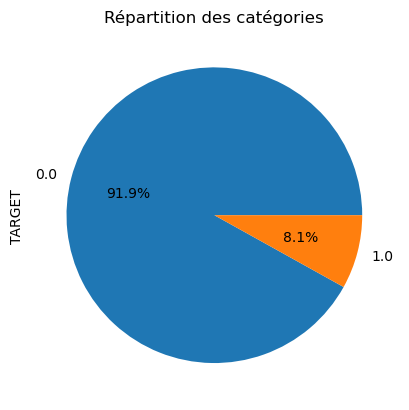

In [55]:
DataFinal.TARGET.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des catégories")

# Exportation des fichiers au format CSV

In [58]:
from tqdm import tqdm
# Séparation des données entre anciens et nouveaux clients
anciens_clients_df = DataFinal[DataFinal['TARGET'].notna()]

# Suppression de la colonne 'SK_ID_CURR' car elle n'est pas utile pour les anciens clients
del anciens_clients_df['SK_ID_CURR']

nouveaux_clients_df = DataFinal[DataFinal['TARGET'].isna()]

# Chemin vers le répertoire de données
chemin_dossier = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data_clean'

# Chemins complets vers les fichiers CSV avec nouveaux noms
chemin_anciens_clients = rf'{chemin_dossier}\AnciensClients.csv'
chemin_nouveaux_clients_reduits = rf'{chemin_dossier}\NouveauxClientsReduits.csv'
chemin_nouveaux_clients_complets = rf'{chemin_dossier}\NouveauxClientsComplets.csv'
chemin_liste_nouveaux_clients = rf'{chemin_dossier}\ListeNouveauxClients.csv'

# Barre de progression pour le traitement des fichiers
tasks = [
    ("Exportation des anciens clients", anciens_clients_df, chemin_anciens_clients),
    ("Réduction des nouveaux clients", nouveaux_clients_df.iloc[:100, :], chemin_nouveaux_clients_reduits),
    ("Exportation des nouveaux clients complets", nouveaux_clients_df, chemin_nouveaux_clients_complets),
    ("Création de la liste des nouveaux clients", pd.DataFrame(nouveaux_clients_df.iloc[:100, :]['SK_ID_CURR']), chemin_liste_nouveaux_clients)
]

for description, df, chemin in tqdm(tasks, desc="Progression"):
    print(f"\n{description} en cours...")
    df.to_csv(chemin, index=False)

print("\nTous les fichiers ont été créés avec succès !")

Progression:   0%|          | 0/4 [00:00<?, ?it/s]


Exportation des anciens clients en cours...


Progression:  25%|██▌       | 1/4 [02:13<06:41, 133.92s/it]


Réduction des nouveaux clients en cours...

Exportation des nouveaux clients complets en cours...


Progression: 100%|██████████| 4/4 [02:35<00:00, 38.96s/it] 


Création de la liste des nouveaux clients en cours...

Tous les fichiers ont été créés avec succès !
